In [46]:
### PART 1: Simple Markowitz-Model implementation to estimate weightage of each stock in portfolio, where portfolio will have highest sharpe ratio

# Step 1: Import modules and define constants
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# On avge, 252 trading days a year
NUM_TRADING_DAYS = 252

# Generate random w (diff. portfolios)
NUM_PORTFOLIOS = 10000

# Our portfolio stocks
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

# Historical data - define START, END dates
start_date = '2010-01-01'
end_date = '2023-10-01'

In [47]:
# Step 2: Data retrieval and Visualisation
def download_data():
    # name of stock as key, stock values 2010-2023
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
    return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

In [48]:
# Step 3: Returns calculation and Portfolio Statistics
# To calculate return using normalisation, show statistics using annual metrics
def calculate_return(data):
    # Normalization - to measure variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]                    # Don't need first row of dataset, since values are NaN

def show_statistics(returns):
    # Instead of daily metrics, use annual metrics
    annual_mean = returns.mean() * NUM_TRADING_DAYS
    annual_covariance = returns.cov() * NUM_TRADING_DAYS
    print("Annual Mean Returns:")
    print(annual_mean)
    print("Annual Covariance Matrix:")
    print(annual_covariance)

In [49]:
# Step 4: To visaulise efficient frontier and displau portfolio metrics
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)


# Generate multiple portfolios: Display their efficient frontier
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [50]:
# Step 5: Portfolio Generation
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        # Generate random weight
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_mean = np.sum(returns.mean() * w) * NUM_TRADING_DAYS
        portfolio_risk = np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w)))
        portfolio_means.append(portfolio_mean)
        portfolio_risks.append(portfolio_risk)

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


In [51]:
# Step 6: Portfolio Optimization Functions
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

# Scipy optimize module can find the minimum of a given function
# Maximum of f(x) is minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

# Constraints: Sum of weights = 1
# f(x) = 0 this is the function to minimize
def optimize_portfolio(weights, returns):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Weights can be 1 at most: 1 when 100% of money invested in single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP', bounds=bounds, constraints=constraints)


In [52]:
# Step 7: Portfolio Results Presentation
def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio weights:", optimum['x'].round(3))
    expected_return, volatility, sharpe_ratio = statistics(optimum['x'].round(3), returns)
    print(f"Expected return: {expected_return}")
    print(f"Expected volatility (standard deviation): {volatility}")
    print(f"Sharpe ratio: {sharpe_ratio}")

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

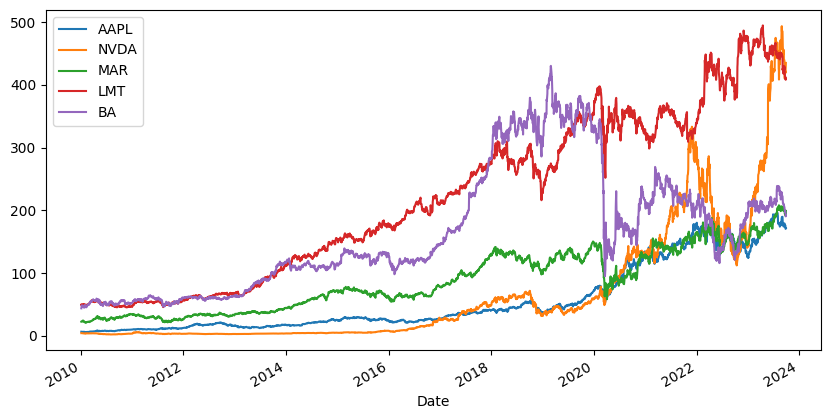



Annual Mean Returns:
AAPL    0.238519
NVDA    0.337451
MAR     0.157839
LMT     0.153483
BA      0.107614
dtype: float64
Annual Covariance Matrix:
          AAPL      NVDA       MAR       LMT        BA
AAPL  0.080627  0.064419  0.036103  0.021053  0.041491
NVDA  0.064419  0.200282  0.054602  0.025807  0.060011
MAR   0.036103  0.054602  0.098672  0.022343  0.065004
LMT   0.021053  0.025807  0.022343  0.044809  0.036176
BA    0.041491  0.060011  0.065004  0.036176  0.130475




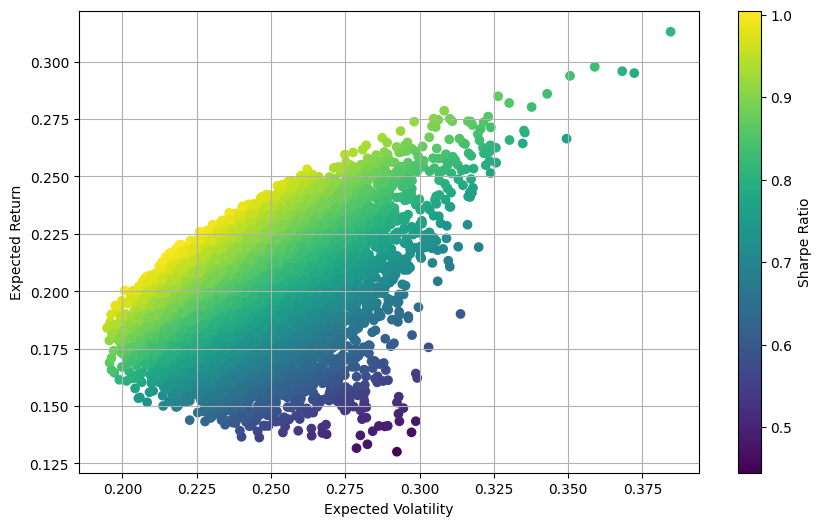



Optimal portfolio weights: [0.364 0.182 0.005 0.45  0.   ]
Expected return: 0.2180933109210677
Expected volatility (standard deviation): 0.2153694114973452
Sharpe ratio: 1.012647568681108


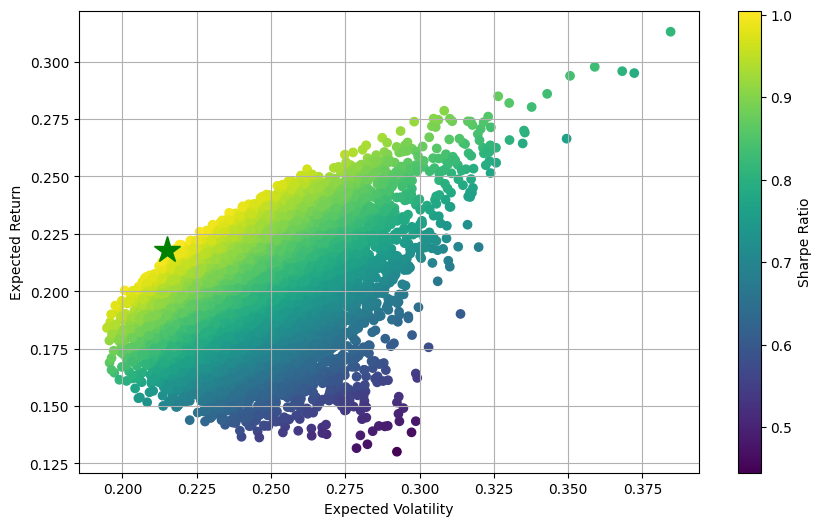

In [53]:
# Main Workflow
# First output: Display stock prices of the 5 stocks, using yfinance
dataset = download_data()
show_data(dataset)
print('\n')

# Second output: Annual Mean returns and covariance matrix of stocks in portfolio
log_daily_returns = calculate_return(dataset)
show_statistics(log_daily_returns)
print('\n')

# Third output: Display Scatterplot of expected return against expected volatility, color coded by sharpe ratio
weights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)
print('\n')

# Fourth output: Display most optimal portfolio (highest sharpe ratio), denoted by green star
# Each value in the list for optimal portfolio shows the corresponding optimal percentage each stock should take in portfolio
optimum = optimize_portfolio(weights, log_daily_returns)
print_optimal_portfolio(optimum, log_daily_returns)
show_optimal_portfolio(optimum, log_daily_returns, means, risks)

In [76]:
### PART 2: Analysing of the 5 stock prices, with incorporation of their corresponding sentiment score (extracted using NLP and FinBert)
### NOTE: Wil not be forecasting prices because there are measured in absolute terms and thus harder to compare across time and other assets.
###       Hence, will be forecasting daily returns instead

# Step 1: Import modules and load data
import yfinance as yf
import math
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']
stock_data = yf.download(stocks, start='2010-01-01', end='2023-10-20', group_by='tickers')
stock_data.head()

[*********************100%%**********************]  5 of 5 completed


NVDA                                                   LMT  \
              Open   High     Low   Close Adj Close    Volume       Open   
Date                                                                       
2010-01-04  4.6275  4.655  4.5275  4.6225  4.240800  80020400  75.870003   
2010-01-05  4.6050  4.740  4.6050  4.6900  4.302727  72864800  76.620003   
2010-01-06  4.6875  4.730  4.6425  4.7200  4.330251  64916800  76.099998   
2010-01-07  4.6950  4.715  4.5925  4.6275  4.245388  54779200  76.169998   
2010-01-08  4.5900  4.670  4.5625  4.6375  4.254562  47816800  74.349998   

                                             ...         BA             \
                 High        Low      Close  ...        Low      Close   
Date                                         ...                         
2010-01-04  76.949997  75.519997  76.849998  ...  54.799999  56.180000   
2010-01-05  77.790001  76.550003  77.650002  ...  56.000000  58.020000   
2010-01-06  77.190002  75.849998  76.510002  ...  57.880001  59.779999   
2010-01-07  76.199997  73.610001  74.410004  ...  59.020000  62.200001   
2010-01-08  75.940002  74.320000  75.610001  ...  60.860001  61.599998   

                                     AAPL                                \
            Adj Close    Volume      Open      High       Low     Close   
Date                                                                      
2010-01-04  43.777554   6186700  7.622500  7.660714  7.585000  7.643214   
2010-01-05  45.211330   8867800  7.664286  7.699643  7.616071  7.656429   
2010-01-06  46.582802   8836500  7.656429  7.686786  7.526786  7.534643   
2010-01-07  48.468555  14379100  7.562500  7.571429  7.466071  7.520714   
2010-01-08  48.001007   7146600  7.510714  7.571429  7.466429  7.570714   

                                 
           Adj Close     Volume  
Date                             
2010-01-04  6.487534  493729600  
2010-01-05  6.498750  601904800  
2010-01-06  6.395379  552160000  
2010-01-07  6.383556  477131200  
2010-01-08  6.425995  447610800  

[5 rows x 30 columns]

In [77]:
# Step 2: Clean and explore data
stock_data.describe()

NVDA                                                      \
              Open         High          Low        Close    Adj Close   
count  3473.000000  3473.000000  3473.000000  3473.000000  3473.000000   
mean     67.350733    68.593902    66.066085    67.381228    67.105124   
std      98.896408   100.733723    96.943027    98.886316    98.920440   
min       2.180000     2.262500     2.162500     2.220000     2.036686   
25%       4.182500     4.250000     4.107500     4.185000     3.839426   
50%      23.025000    23.152500    22.512501    22.955000    22.627165   
75%      78.074997    79.080002    75.947502    78.025002    77.774620   
max     502.160004   502.660004   489.579987   493.549988   493.509338   

                             LMT                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  3.473000e+03  3473.000000  3473.000000  3473.000000  3473.000000  ...   
mean   5.068752e+07   250.547558   252.693110   248.401342   250.563409  ...   
std    3.143003e+07   129.657013   130.908460   128.383067   129.615066  ...   
min    4.564400e+06    66.989998    68.400002    66.360001    66.870003  ...   
25%    3.074880e+07   106.910004   107.709999   106.260002   107.050003  ...   
50%    4.351480e+07   255.100006   257.000000   252.770004   254.970001  ...   
75%    6.167640e+07   362.299988   365.579987   359.450012   361.989990  ...   
max    3.692928e+08   502.000000   508.100006   498.000000   501.410004  ...   

                BA                                                 AAPL  \
               Low        Close    Adj Close        Volume         Open   
count  3473.000000  3473.000000  3473.000000  3.473000e+03  3473.000000   
mean    171.682289   173.751471   164.182916  7.310036e+06    58.096316   
std      93.042401    94.168854    96.619565  8.694362e+06    53.667291   
min      54.799999    56.180000    43.777554  7.889000e+05     6.870357   
25%      99.300003   100.750000    86.017105  3.443600e+06    19.500000   
50%     143.979996   145.860001   132.949997  4.725000e+06    31.990000   
75%     215.910004   218.110001   218.110001  7.371100e+06    79.665001   
max     440.190002   440.619995   430.299988  1.032128e+08   196.240005   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  3473.000000  3473.000000  3473.000000  3473.000000  3.473000e+03  
mean     58.731987    57.488376    58.135312    56.176044  2.449506e+08  
std      54.301794    53.084844    53.719198    54.152633  2.208448e+08  
min       7.000000     6.794643     6.858929     5.821835  3.145820e+07  
25%      19.660000    19.245001    19.445356    16.960619  9.453760e+07  
50%      32.220001    31.719999    31.950001    28.829893  1.550880e+08  
75%      80.587502    79.125000    79.750000    78.009239  3.325616e+08  
max     198.229996   195.279999   196.449997   196.185074  1.880998e+09  

[8 rows x 30 columns]

In [94]:
# Check for presence of missing values
missing_values_count = stock_data.isnull().sum()
missing_values_count

NVDA  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
LMT   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
MAR   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
BA    Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
AAPL  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
dtype: int64

In [78]:
# Check shape of dataframe
stock_data.shape

(3473, 30)

In [79]:
# Check columns of dataframe
stock_data.columns

MultiIndex([('NVDA',      'Open'),
            ('NVDA',      'High'),
            ('NVDA',       'Low'),
            ('NVDA',     'Close'),
            ('NVDA', 'Adj Close'),
            ('NVDA',    'Volume'),
            ( 'LMT',      'Open'),
            ( 'LMT',      'High'),
            ( 'LMT',       'Low'),
            ( 'LMT',     'Close'),
            ( 'LMT', 'Adj Close'),
            ( 'LMT',    'Volume'),
            ( 'MAR',      'Open'),
            ( 'MAR',      'High'),
            ( 'MAR',       'Low'),
            ( 'MAR',     'Close'),
            ( 'MAR', 'Adj Close'),
            ( 'MAR',    'Volume'),
            (  'BA',      'Open'),
            (  'BA',      'High'),
            (  'BA',       'Low'),
            (  'BA',     'Close'),
            (  'BA', 'Adj Close'),
            (  'BA',    'Volume'),
            ('AAPL',      'Open'),
            ('AAPL',      'High'),
            ('AAPL',       'Low'),
            ('AAPL',     'Close'),
            ('AAPL',

In [ ]:
aapl = yf.Ticker('AAPL')
aapl.info

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Line charts for AAPL: 



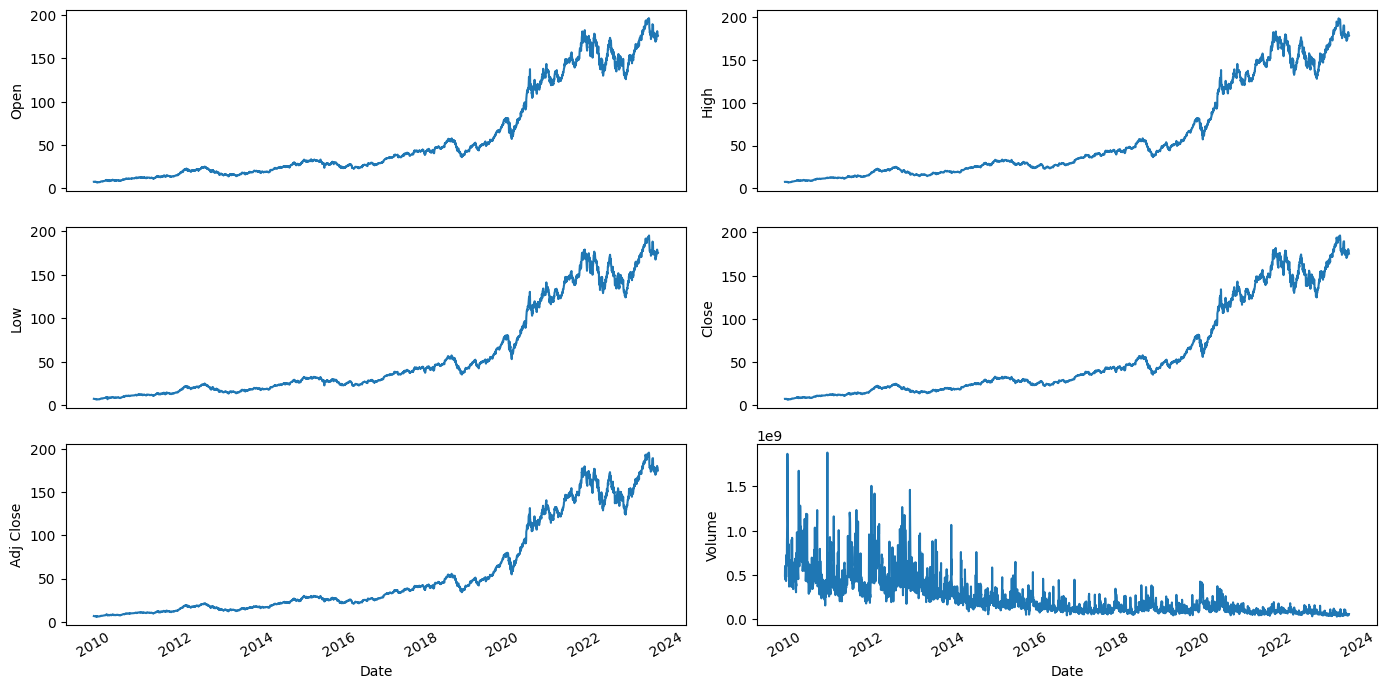

Line charts for NVDA: 



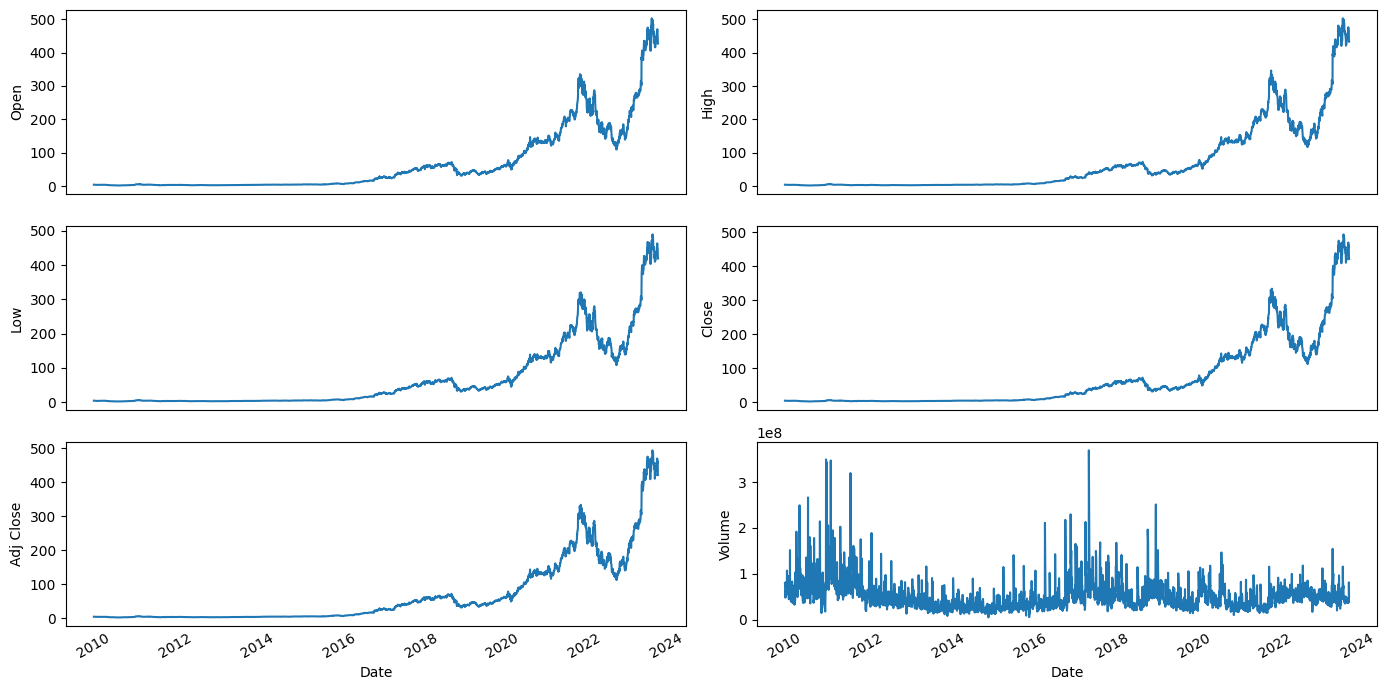

Line charts for MAR: 



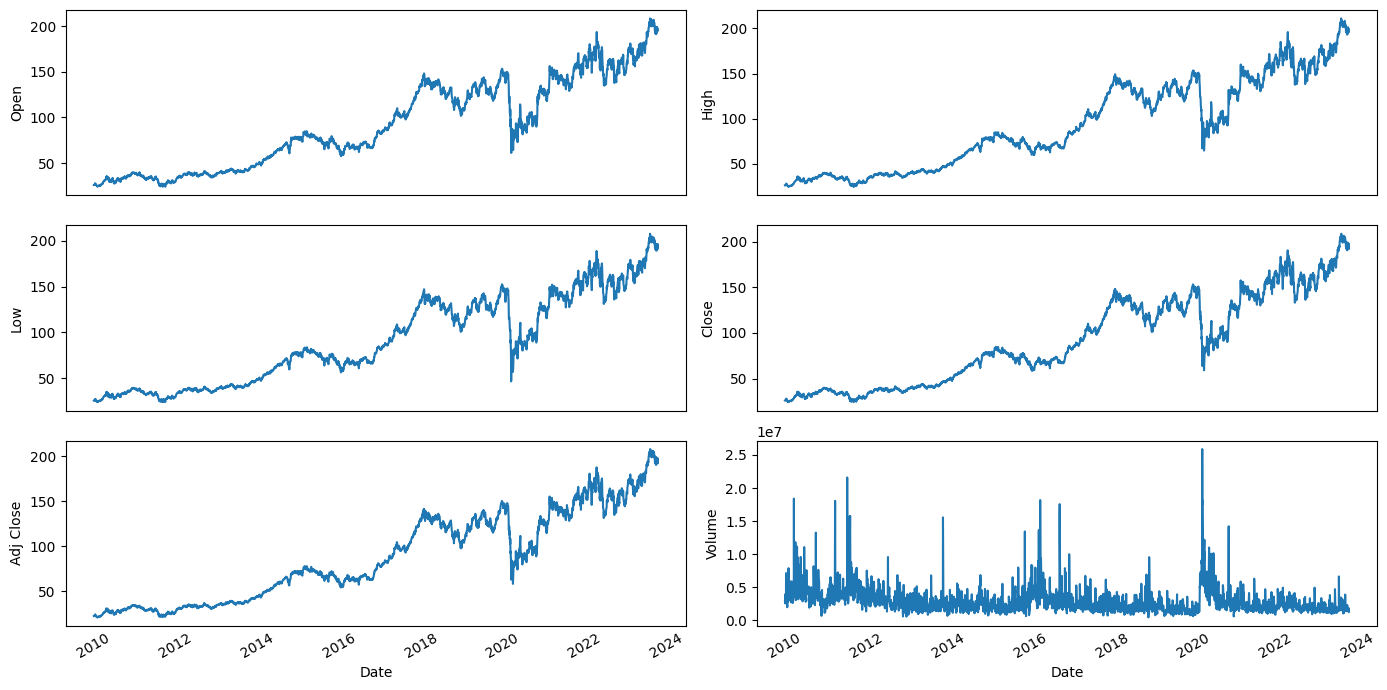

Line charts for LMT: 



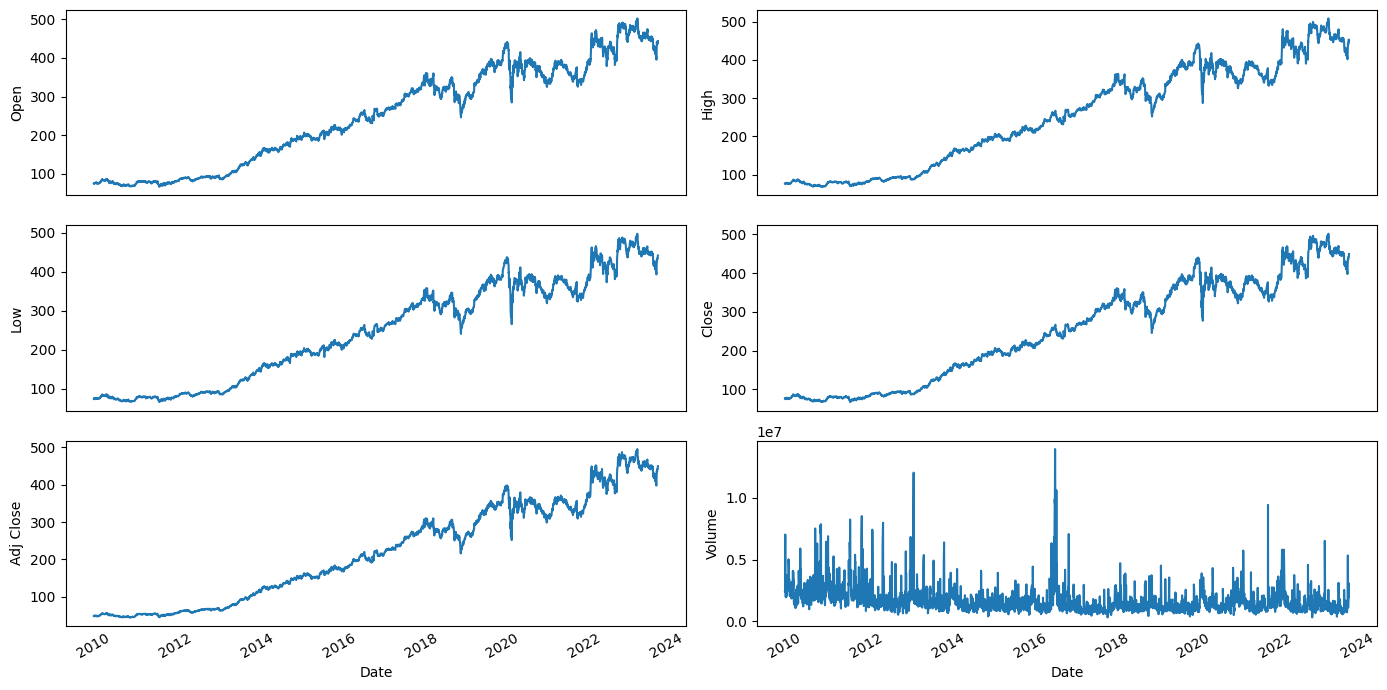

Line charts for BA: 



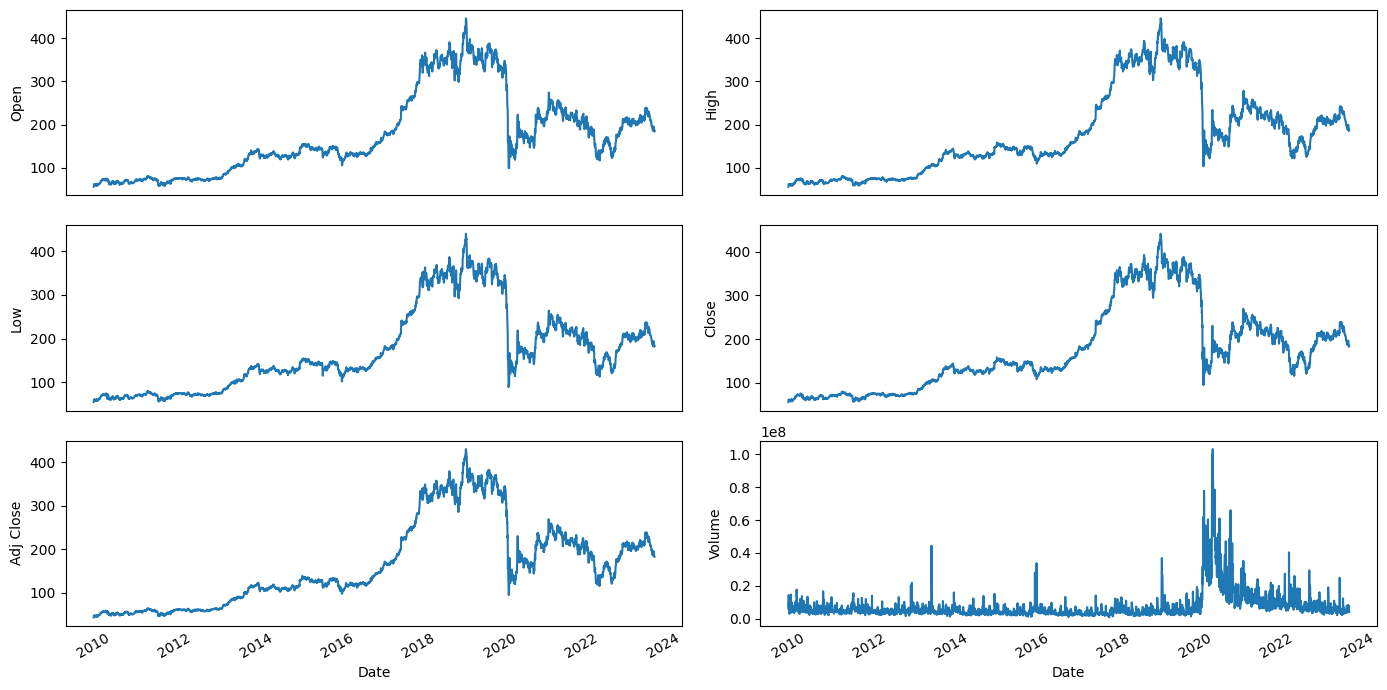

In [92]:
# Explore data: Create line charts for columns of dataset
# Define the DataFrame to plot (Will display line charts for 5 stocks separately here for ease of visualisation)
aapl_df = yf.download('AAPL', start='2010-01-01', end='2023-10-20')
nvda_df = yf.download('NVDA', start='2010-01-01', end='2023-10-20')
mar_df = yf.download('MAR', start='2010-01-01', end='2023-10-20')
lmt_df = yf.download('LMT', start='2010-01-01', end='2023-10-20')
ba_df = yf.download('BA', start='2010-01-01', end='2023-10-20')

# Function to plot line chart of every stock in stock_df (For a quick glance)
def plot_line_charts(stock_df):
    # Plot line charts
    df_plot = stock_df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

print("Line charts for AAPL: \n")
plot_line_charts(aapl_df)
print("Line charts for NVDA: \n")
plot_line_charts(nvda_df)
print("Line charts for MAR: \n")
plot_line_charts(mar_df)
print("Line charts for LMT: \n")
plot_line_charts(lmt_df)
print("Line charts for BA: \n")
plot_line_charts(ba_df)

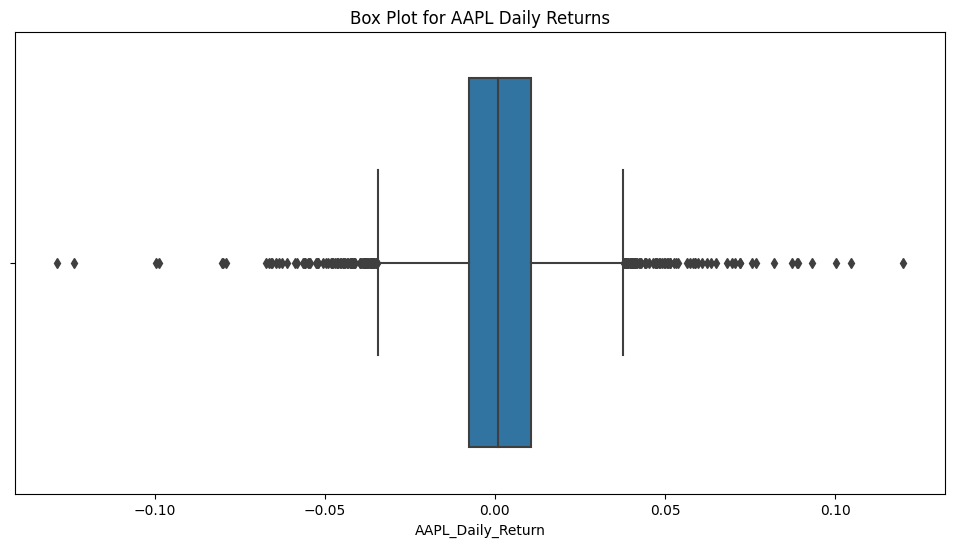

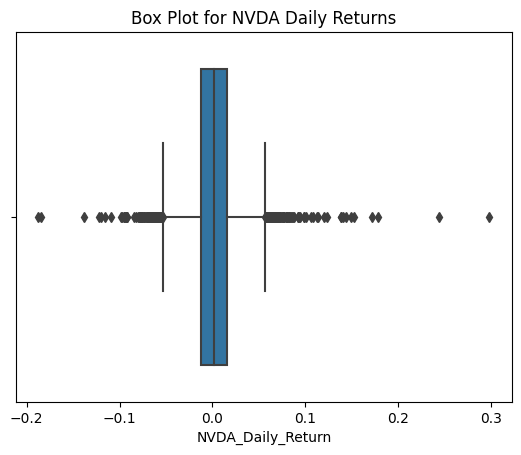

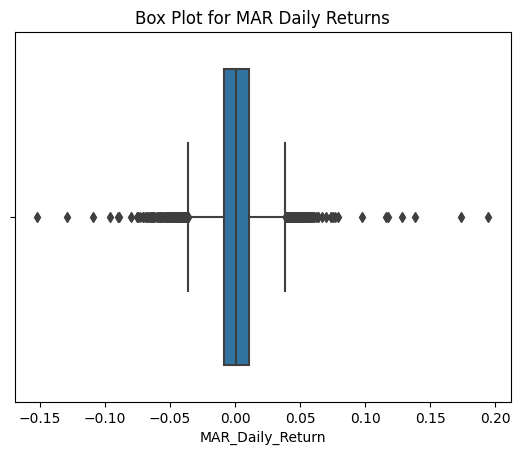

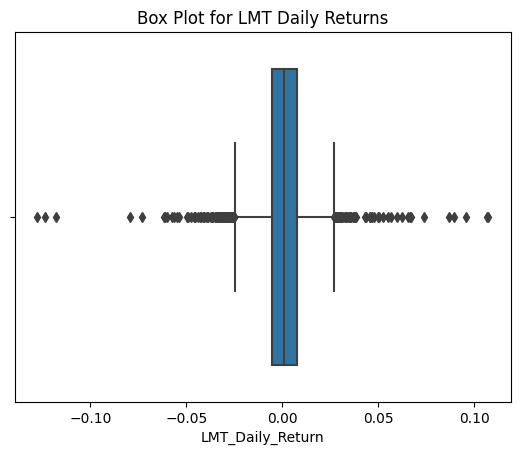

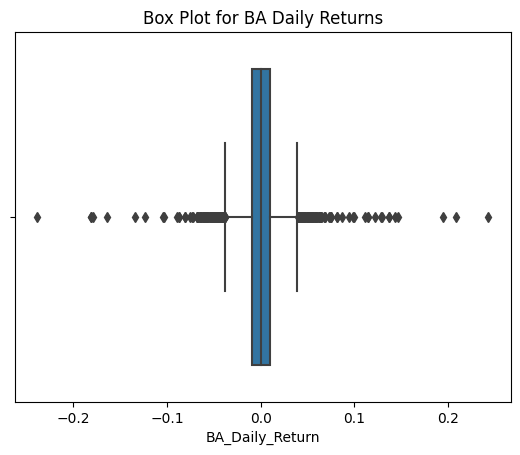

In [96]:
# Step 3: Feature Engineering
# Forecast daily returns by creating return column and analyse possible outliers using boxplot
for stock in stocks:
    stock_data[f'{stock}_Daily_Return'] = stock_data[stock]['Adj Close'].pct_change()

# Perform data analysis to identify possible outliers
plt.figure(figsize=(12, 6))
for stock in stocks:
    sns.boxplot(x=stock_data[f'{stock}_Daily_Return'])
    plt.title(f'Box Plot for {stock} Daily Returns')
    plt.show()
    print("\n")

In [97]:
# Using log transformation to reduce the impact of outliers, instead of removing them
# Since we feel that outliers are meaningful and representative of actual market conditions/events
stock_data.head()

NVDA                                                   LMT  \
              Open   High     Low   Close Adj Close    Volume       Open   
Date                                                                       
2010-01-04  4.6275  4.655  4.5275  4.6225  4.240800  80020400  75.870003   
2010-01-05  4.6050  4.740  4.6050  4.6900  4.302727  72864800  76.620003   
2010-01-06  4.6875  4.730  4.6425  4.7200  4.330251  64916800  76.099998   
2010-01-07  4.6950  4.715  4.5925  4.6275  4.245388  54779200  76.169998   
2010-01-08  4.5900  4.670  4.5625  4.6375  4.254562  47816800  74.349998   

                                             ...      AAPL            \
                 High        Low      Close  ...      High       Low   
Date                                         ...                       
2010-01-04  76.949997  75.519997  76.849998  ...  7.660714  7.585000   
2010-01-05  77.790001  76.550003  77.650002  ...  7.699643  7.616071   
2010-01-06  77.190002  75.849998  76.510002  ...  7.686786  7.526786   
2010-01-07  76.199997  73.610001  74.410004  ...  7.571429  7.466071   
2010-01-08  75.940002  74.320000  75.610001  ...  7.571429  7.466429   

                                          AAPL_Daily_Return NVDA_Daily_Return  \
               Close Adj Close     Volume                                       
Date                                                                            
2010-01-04  7.643214  6.487534  493729600               NaN               NaN   
2010-01-05  7.656429  6.498750  601904800          0.001729          0.014603   
2010-01-06  7.534643  6.395379  552160000         -0.015906          0.006397   
2010-01-07  7.520714  6.383556  477131200         -0.001849         -0.019598   
2010-01-08  7.570714  6.425995  447610800          0.006648          0.002161   

           MAR_Daily_Return LMT_Daily_Return BA_Daily_Return  
                                                              
Date                                                          
2010-01-04              NaN              NaN             NaN  
2010-01-05         0.005791         0.010409        0.032751  
2010-01-06         0.002879        -0.014681        0.030335  
2010-01-07         0.003947        -0.027447        0.040482  
2010-01-08         0.002145         0.016127       -0.009646  

[5 rows x 35 columns]

In [ ]:
# Step 3: Feature Engineering
# Will be incorporating indicators from chart analysis to measure price momentum




